# Degree-tuned polynomial regression

Here I show how to automatically choose the degree of polynomial to use for fitting your data using Scikit-Learn.
The content of this notebook is taken by combining concepts from scikit-learn tutorials
- [Non-linear feature engineering](https://inria.github.io/scikit-learn-mooc/python_scripts/linear_regression_non_linear_link.html)
- [Hyperparameter tuning by grid-search](https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_grid_search.html)

In [72]:
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

linewidth = 4

## Generate synthetic data

In [99]:
n_samples = 1000
df = pd.DataFrame({'x': np.linspace(-1.4, 1.4, n_samples), })
poly_obj = np.poly1d([1,-0.5,0, 0,])
df['gr_truth'] = poly_obj(df['x'])
df['y'] = df['gr_truth'] + np.random.normal(0, 0.7, n_samples)
data = df['x'].values.reshape(-1,1)
target = df['y'].values.reshape(-1, 1)
truth = df['gr_truth'].values.reshape(-1,1)

Text(0, 0.5, 'target')

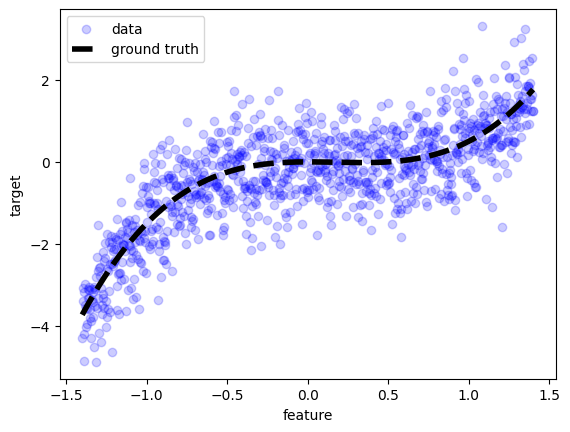

In [101]:
#visualize
plt.scatter(df['x'], df['y'], label='data', color="blue", alpha=0.2)
plt.plot(df['x'], df['gr_truth'], label='ground truth',
         color='black', linewidth=linewidth, linestyle="--",)
plt.legend()
plt.xlabel("feature")
plt.ylabel("target")

## Split data into test and train

In [102]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=42)

## Polynomial regression

In [103]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
    ("deg_constructor",PolynomialFeatures(degree=3, include_bias=False)),
    ("regressor", LinearRegression()),
    ]
)
model

Pipeline(steps=[('deg_constructor',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('regressor', LinearRegression())])

## Automating tuning of degree

In [114]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    "deg_constructor__degree": (1,2,3,4,5),
    "deg_constructor__include_bias": (True, False),
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

CPU times: user 18.6 ms, sys: 3.49 ms, total: 22.1 ms
Wall time: 51.2 ms


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('deg_constructor',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('regressor', LinearRegression())]),
             n_jobs=2,
             param_grid={'deg_constructor__degree': (1, 2, 3, 4, 5),
                         'deg_constructor__include_bias': (True, False)})

In [115]:
print(f"The best set of parameters is: {model_grid_search.best_params_}")

The best set of parameters is: {'deg_constructor__degree': 3, 'deg_constructor__include_bias': True}


# Analyzing results of hyperparameter search

In [116]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values("mean_test_score", ascending=False)

# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,degree,include_bias,mean_test_score,std_test_score,rank_test_score
4,3,True,0.681248,0.022430,1
5,3,False,0.681248,0.022430,1
7,4,False,0.677584,0.021532,3
6,4,True,0.677584,0.021532,4
8,5,True,0.673500,0.020776,5
9,5,False,0.673500,0.020776,6
2,2,True,0.573850,0.018215,7
3,2,False,0.573850,0.018215,7
0,1,True,0.519868,0.004590,9
1,1,False,0.519868,0.004590,10


## Visualizing the best fit model

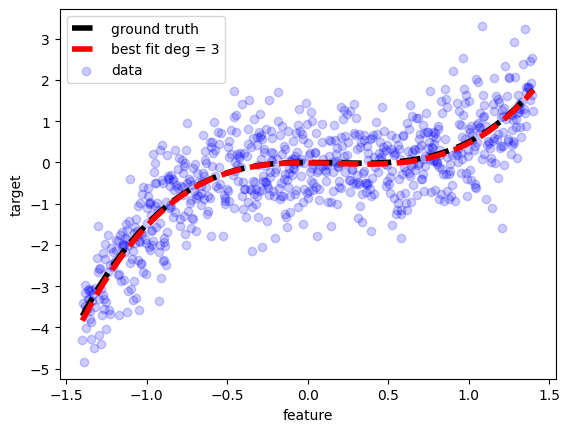

In [117]:

plt.plot(data, truth, color="black", label="ground truth",
         linewidth=linewidth, linestyle="--",)
plt.plot(data, model_grid_search.predict(data),
         label="best fit deg = " + str(model_grid_search.best_params_['deg_constructor__degree']),  
         linewidth = linewidth, color = "red", linestyle = "--",
         )
plt.scatter(data_train, target_train, color="blue", label="data", alpha = 0.2)
plt.xlabel("feature")
plt.ylabel("target")
plt.legend()

Here we see something interesting. Even though the data was generated using a fifth degree polynomial, a third degree polynomial was enough to capture the data. 

## Conclusion

This hyperparameter search will reduce the number of decisions taken by the analyser and will make your code more robust to non-linearities in data. This procedure also ensures to find the best balancce between underfiiting and overfitting. This is not only a handy tool but should also be included as a "good practice" in any analysis pipeline/workflow.